In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
import matplotlib.patches as patches
import cv2
import pandas as pd
import sys
import poissonimageediting as poisson
from tqdm.auto import tqdm
import torch
from pietorch.functional import blend, blend_wide
from torchvision.transforms import functional as TF
from PIL import Image
np.set_printoptions(threshold=sys.maxsize)

/home/vann/anaconda3/envs/dip_final/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image = cv2.imread('data/01.png').astype(np.uint8)
dataset_images_dir = "data/holiday_images"
target_df = pd.read_pickle('data/target_df.pkl')
dataset_df = pd.read_pickle('data/holiday_df.pkl')

In [3]:
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

target_descriptors = np.array(target_df['descriptor'].tolist(), dtype = np.float32)
dataset_descriptors = np.array(dataset_df['descriptor'].tolist(), dtype = np.float32)

matches = matcher.match(target_descriptors, dataset_descriptors)

target_df['match_idx'] = np.array([match.trainIdx for match in matches])

In [4]:
target_df = target_df.sort_values(by = ['size'], ascending = [False])
# filter size that is too small
target_df_filtered = target_df[target_df['size'] > 1000]
print(target_df_filtered.shape)

(607, 13)


In [5]:
dataset_df.shape


(152327, 12)

In [6]:
def warp_and_paste_ellipse(source_image_path, destination_image, source_params, destination_params):
    # Load the source and destination images
    source_image = cv2.imread(source_image_path).astype(np.uint8)

    # Unpack ellipse parameters
    u, v, major_axis_length, minor_axis_length, angle = source_params
    u2, v2, major_axis_length2, minor_axis_length2, angle2 = destination_params

    # Define the source ellipse parameters (from the source image)
    center1 = (int(u), int(v))
    axes1 = (int(major_axis_length), int(minor_axis_length))
    angle1 = np.degrees(angle)

    # Define the destination ellipse parameters (on the destination image)
    center2 = (int(u2), int(v2))
    axes2 = (int(major_axis_length2), int(minor_axis_length2))
    angle2 = np.degrees(angle2)

    # Create a mask for the source ellipse
    mask = np.zeros_like(source_image)
    cv2.ellipse(mask, center1, axes1, angle1, 0, 360, (255, 255, 255), -1)

    # Extract the source ellipse region
    source_ellipse_region = cv2.bitwise_and(source_image, mask)

    # Define the bounding box around the source ellipse
    src_rect = cv2.boxPoints(((center1[0], center1[1]), (axes1[0] * 2, axes1[1] * 2), angle1))
    src_rect = np.int0(src_rect)

    # Define the bounding box around the destination ellipse
    dst_rect = cv2.boxPoints(((center2[0], center2[1]), (axes2[0] * 2, axes2[1] * 2), angle2))
    dst_rect = np.int0(dst_rect)

    # Compute the perspective transformation matrix
    M = cv2.getPerspectiveTransform(np.float32(src_rect), np.float32(dst_rect))

    # Warp the source ellipse region to the shape of the destination ellipse
    warped_ellipse_region = cv2.warpPerspective(source_ellipse_region, M, (destination_image.shape[1], destination_image.shape[0]))

    # Get the bounding box of the destination ellipse
    x, y, w, h = cv2.boundingRect(dst_rect)

    # Crop the warped source ellipse to its bounding box
    warped_source_ellipse_bbox = warped_ellipse_region[y:y+h, x:x+w]
    # color
    # if (warped_source_ellipse_bbox is not None):
        # warped_source_ellipse_bbox = cv2.cvtColor(warped_source_ellipse_bbox, cv2.COLOR_BGR2RGB)
    
    # get the top left corner points of the bounding box in the image
    corner = (x, y)
    
    return warped_source_ellipse_bbox, corner

In [8]:
canvas = np.zeros_like(image)
# use enumerate to get the index of the row

# for index, row in tqdm(target_df_filtered.iterrows(), total=target_df_filtered.shape[0]):
# use enumerate and tqdm
for i, (index, row) in enumerate(tqdm(target_df_filtered.iterrows(), total=target_df_filtered.shape[0])):
    target_u, target_v = row['coordinate']
    target_A = row['matrix']
    target_major_axis_length = row['semi_major_axis']
    target_minor_axis_length = row['semi_minor_axis']
    target_angle = row['angle']
    
    match_idx = row['match_idx']
    match_image_name  = dataset_df.loc[match_idx, 'image_name']
    match_u, match_v = dataset_df.loc[match_idx, 'coordinate']
    match_A = np.array(dataset_df.loc[match_idx, 'matrix'])
    match_major_axis_length = dataset_df.loc[match_idx, 'semi_major_axis']
    match_minor_axis_length = dataset_df.loc[match_idx, 'semi_minor_axis']
    match_angle = dataset_df.loc[match_idx, 'angle']
    
    match_image_path = f"{dataset_images_dir}/{match_image_name}"

    
    source_params = (match_u, match_v, match_major_axis_length, match_minor_axis_length, match_angle)
    destination_params = (target_u, target_v, target_major_axis_length, target_minor_axis_length, target_angle)

    ellipse, corner = warp_and_paste_ellipse(match_image_path, canvas, source_params, destination_params)
    
    if ellipse is not None:
        # Get top-left corner coordinates
        x, y = corner
        
        # Check if there is overlap
        canvas_region = canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]]
        
        if np.count_nonzero(canvas_region) == 0:
            # No overlap, paste directly
            canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]] = ellipse
        else:
            target = TF.to_tensor(canvas)
            source = TF.to_tensor(ellipse)
            mask = (source != 0).any(dim=0).float()
            corner_cood = torch.tensor([y, x])
            
            result = blend(target, source, mask, corner_cood, True, channels_dim=0)
            canvas = TF.to_pil_image(result)
            canvas = np.array(canvas)
            
        # canvas will be result numpy
        # canvas[y:y+ellipse.shape[0], x:x+ellipse.shape[1]] = ellipse
        # save the canvas every iteration
        cv2.imwrite(f'output/output{i:3d}.png', canvas)

  0%|          | 0/607 [00:00<?, ?it/s]/tmp/ipykernel_463587/363538235.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  src_rect = np.int0(src_rect)
/tmp/ipykernel_463587/363538235.py:32: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  dst_rect = np.int0(dst_rect)
100%|██████████| 607/607 [01:07<00:00,  9.02it/s]


In [8]:
canvas.shape, target.shape, source.shape, mask.shape, corner_cood

((640, 794, 3),
 torch.Size([3, 640, 794]),
 torch.Size([3, 258, 482]),
 torch.Size([258, 482]),
 tensor([291, 256]))

In [27]:
print(mask)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


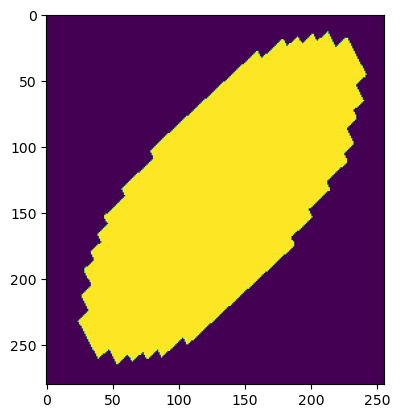

In [11]:

plt.imshow(mask)